# LANDIS II model output exploration

#### Working with the Camp Navajo study model output 

### Required libraries, Variable and path definition

In [1]:
# Specify inline plots for notebook
%matplotlib inline

# Libraries -- overkill for the time being
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
import gdal


inputDir = '/home/nikko/Research/LANDIS/Camp_Navajo/Output/'
outputDir = '/home/nikko/Research/LANDIS/Camp_Navajo/Output/Plots'

### Function definition

In [2]:
# Generator function to whip up the directory structure for the model outputs.
# I'm going to use the existing structure handed to me for the Camp Navajo (CN)
# study, and run with it. Here,we're creating a directory and file generator function
def dirs(path):
    for dir in os.listdir(path):
        if os.path.isdir(os.path.join(path, dir)):
            yield dir

def files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

# Now we need a function to gather the full paths for each simulation iteration set.
# This requires the apropriate simulation name as a parameter
def retrieveIterationPaths(simVar):
    iterations = []
    iterations_f = []
    gen = dirs(simNames_f[0] + '/')
    for names in gen:
        iterations.append(names)
        iterations_f.append(simNames_f[0] + '/' + names)
    return iterations_f

# For a given iteration path, we can provide a specific map directory and map name
# (because in some cases, a single map directory may contain multiple map types)
def retrieveMapPaths(iteration, mapDir, mapVar):
    fileNames = []
    fileNames_f = []
    gen = files(iteration + '/' + mapDir)
    for names in gen:
        fileNames_f.append(iteration + '/' + names)
        # This is still sort of broken... needs some attention
        matching = [s for s in fileNames_f if 'mapVar' in s]
    return fileNames_f                       

# We're grabbing a bunch of strings for the map names, and the lists aren't ordered
# apropriately. We have to sort the strings to assure the z-stack of rasters that we
# read in are in the correct order. Its actually sort of a pain to do given how the 
# maps are names -- keep this in mind when you specify a new naming convention!
# Namely, use '001' instead of '1', to remove ambiguity between 1,10,100 sorting.
def sortMapList(mapList):
    mapIndices = []
    for mapname in mapList:
        mapIndices.append(mapname.split('-')[1].split('.')[0])
    mapDataFrame = pd.DataFrame(dict(mapPath = mapList, mapIndex = mapIndices))
    mapDataFrame.mapIndex = mapDataFrame.mapIndex.astype(float)
    return mapDataFrame

            
# Linear fit through a raster stack. Pixel by pixel, fit the grid cell value to time.
# Populate the output raster with the slope of the regression. Ultimately here we will
# use the StatsModels module to output fit significance as well as RMSE as a supplemental
# raster.
def linearFit(rasterStack):
    fitRaster = np.zeros((rasterStack.shape[0],rasterStack.shape[1]), 
                         dtype=np.float)
    for row in np.arange(0,rasterStack.shape[0]):
        for column in np.arange(0,rasterStack.shape[1]):
            x = np.arange(0,rasterStack.shape[2])
            y = rasterStack[row][column][:]
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            fitRaster[row][column] = z[0]
    return fitRaster

### Directory and file listing by experiment design
##### Given that every experimental run in LANDIS has a folder hierarchy that is user-defined, combinations of the files() and dirs() generator functions can more or less drill into any set of map types for the iteration of plots or calculations on output throughout the various experimental runs. 

In [3]:
# Start by determining the simulation names used in the experiment
simNames = []
simNames_f = []
gen = dirs(inputDir)
for names in gen:
    simNames.append(names)
    simNames_f.append(inputDir + names)

    
# Tab into one of the simulations and start exploring the structure
# We need to grab the iterations (runs), and file names within each iteration
iterations = []
iterations_f = []
gen = dirs(simNames_f[0] + '/')
for names in gen:
    iterations.append(names)
    iterations_f.append(simNames_f[0] + '/' + names)
    
# Tab into one of the iterations and identify the map types present
# in each run
mapTypes = []
mapTypes_f = []
gen = dirs(iterations_f[0] + '/')
for names in gen:
    mapTypes.append(names)
    mapTypes_f.append(iterations_f[0] + '/' + names)


# Ultimately gotta clean this up for an experiment specific generator that produces
# file paths to all model output per simulation, iterated by run
fileNames = []
fileNames_f = []
gen = files(iterations_f[0])
for names in gen:
    fileNames.append(names)
    fileNames_f.append(iterations_f[0] + '/' + names)


### Example dirs() and files() usage with the CN dataset
##### Here we want to create a cumulative NEE map for each simulation. Each map should represent the mean of the 5 run iterations. First we need to step through the directory structure, and create a way to operate on each output map.

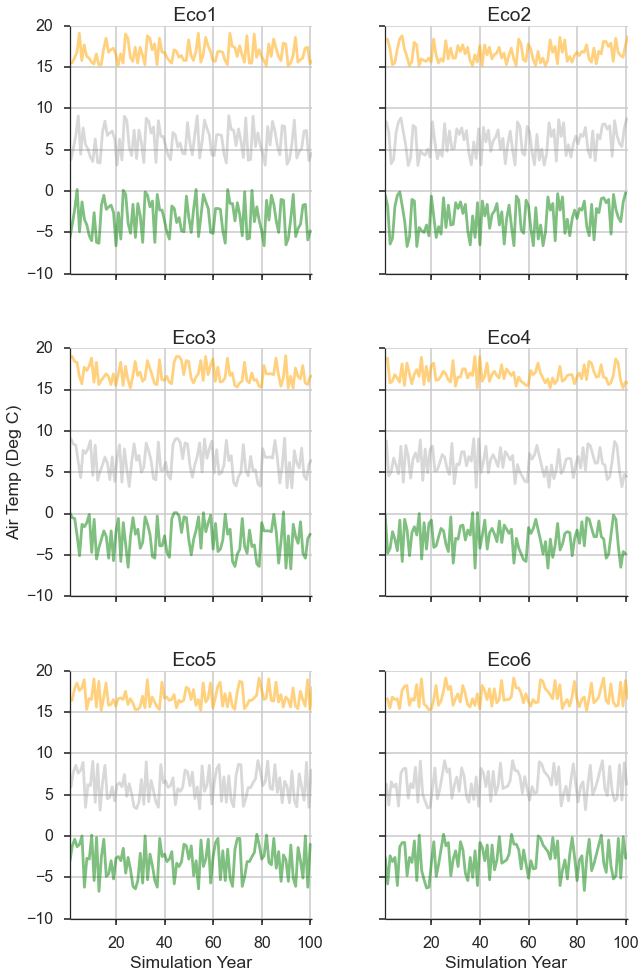

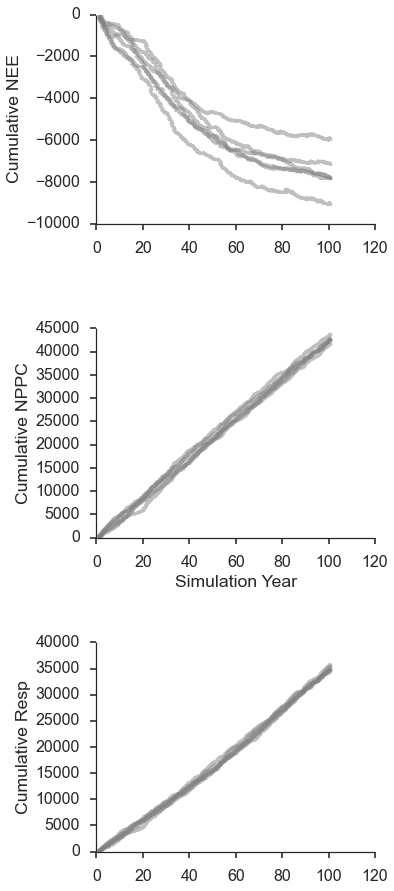

In [6]:
# Start making some plots of the Century file vars, by ecoregion
Century_Monthly = pd.read_csv(fileNames_f[0], sep = ',')
Century_Monthly['TS'] = Century_Monthly.Time + (Century_Monthly[' Month'] - 1)/12


# Air T by Ecoregion
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (10, 16), dpi = 300,
                                                      sharex = True, sharey = True)
plt.subplots_adjust(wspace = .3, hspace = 0.3)
axs = f.axes
idx = 0
sns.despine()
sns.set_style("ticks")
sns.set_context("poster")

for region in np.unique(Century_Monthly[' Ecoregion']):
    ax = axs[idx]
    ax.grid(False)

    thisRegion = Century_Monthly[Century_Monthly[' Ecoregion'] == region]
    thisRegion.groupby('Time').mean().plot(ax = ax, 
        x = 'TS',y = ' T', kind = 'line', alpha = 0.3, c = 'gray')
    thisRegion.groupby('Time').max().plot(ax = ax, 
        x = 'TS',y = ' T', kind = 'line', alpha = 0.5, c = 'orange')
    thisRegion.groupby('Time').min().plot(ax = ax, 
        x = 'TS',y = ' T', kind = 'line', alpha = 0.5, c = 'green')
    ax.set_title(region)
    ax.set_xlabel('Simulation Year')
    if idx == 2:
        ax.set_ylabel('Air Temp (Deg C)')
    ax.legend_ = None

    idx = idx + 1

# Cumulative flux components by Ecoregion
f, ((ax1), (ax2), (ax3)) = plt.subplots(3,1, figsize = (5,15), dpi = 300)

plt.subplots_adjust(wspace = .3, hspace = 0.5)
axs = f.axes
idx = 0
sns.despine()
sns.set_style("ticks")
sns.set_context("poster")

for var in [' NEE',' NPPC',' Resp']:
    for region in np.unique(Century_Monthly[' Ecoregion']):
        ax = axs[idx]
        ax.grid(False)

        thisRegion = Century_Monthly[Century_Monthly[' Ecoregion'] == region]
        ax.plot(thisRegion.TS, thisRegion[var].cumsum(), color = 'grey',
               alpha = 0.5)
        if idx == 1:
            ax.set_xlabel('Simulation Year')
        ax.set_ylabel('Cumulative' +  var)
        ax.legend_ = None

    idx = idx + 1

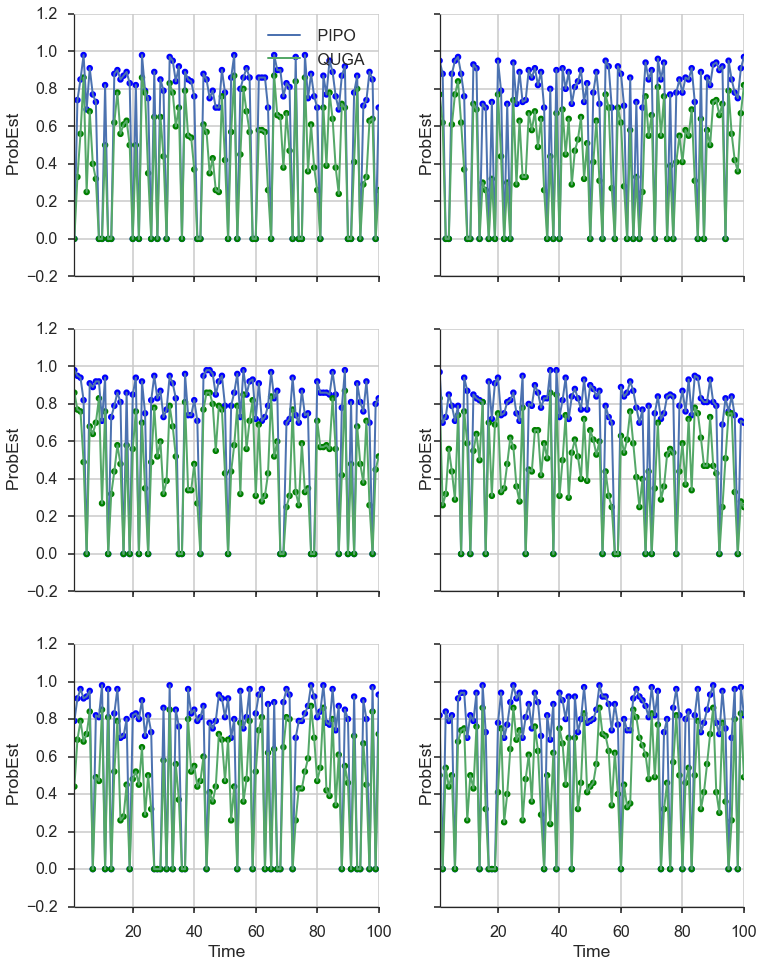

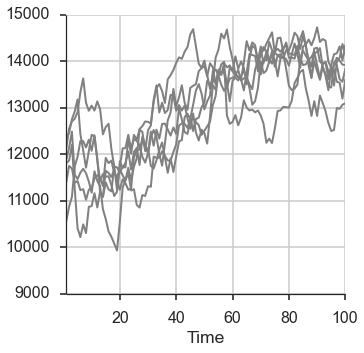

In [7]:
Century_Prob = pd.read_csv(fileNames_f[1], sep = ',')

# Esablishment Probability by Ecoregion
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (12, 16), dpi = 300,
                                                      sharex = True, sharey = True)
plt.subplots_adjust(wspace = .2, hspace = 0.2)
axs = f.axes
idx = 0
sns.despine()
sns.set_style("ticks")
sns.set_context("poster")

for region in np.unique(Century_Prob[' Ecoregion']):
    ax = axs[idx]
    ax.grid(False)
    thisRegion = Century_Prob[Century_Prob[' Ecoregion'] == region]
    for species in np.unique(Century_Prob[' Species']):
        if species == ' PIPO':
            speciesC = 'blue'
        else:
            speciesC = 'green'
        thisSpecies = thisRegion[thisRegion[' Species'] == species]
        thisSpecies.plot(ax = ax, x = 'Time',y = ' ProbEst', lw = 2)
        thisSpecies.plot(kind = 'scatter', ax = ax, x = 'Time',y = ' ProbEst', lw = 2, 
                         color = speciesC)

    if idx == 0:
        ax.legend(np.unique(Century_Prob[' Species']))
    else:
        ax.legend_ = None

    idx = idx + 1
    
# Succesion_log AGB by Ecoregion
Century_log = pd.read_csv(fileNames_f[2], sep = ',')

f, (ax1) = plt.subplots(1,1, figsize = (5, 5), dpi = 300)
plt.subplots_adjust(wspace = .3, hspace = 0.3)
axs = f.axes
idx = 0
sns.despine()
sns.set_style("ticks")
sns.set_context("poster")
ax = ax1
for region in np.unique(Century_log[' Ecoregion']):
    ax.grid(False)
    thisRegion = Century_log[Century_log[' Ecoregion'] == region]
    thisRegion.plot(ax = ax, x = 'Time',y = ' AGB', lw = 2, color = 'gray')
    ax.legend_ = None



### Example drilling through stacks of rasters to generate ensembles

/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 3
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 1
1
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 4
2
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 2
3
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 5
4


<matplotlib.colorbar.Colorbar instance at 0x7f1dc07c6908>

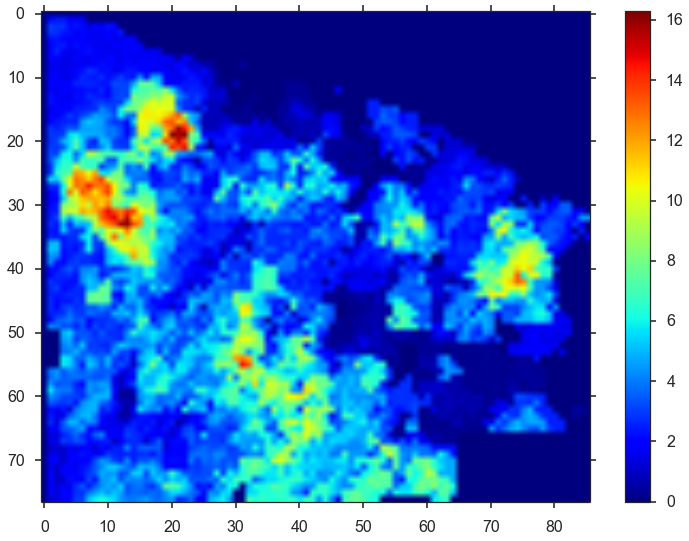

In [8]:
meanBM = np.zeros((77,86), dtype=np.float)
meanBMz = np.zeros((77,86), dtype=np.float)
idx = 0
for iteration in iterations_f:
    print iteration
    totalBM = np.zeros((77,86), dtype=np.float)
    totalBMz = np.zeros((77,86), dtype=np.float)

    count = 0
    MapNames_f = []
    gen = dirs(iteration)
    for names in gen:
        MapNames_f.append(iteration + '/' + names)
    sevm = []
    gen = dirs(MapNames_f[9])
    for names in gen:
        sevm.append(MapNames_f[9] + '/' + names)
    sevmaps = []
    gen = files(sevm[0])
    for names in gen:
        sevmaps.append(sevm[0] + '/' + names)
    
    for sevmap in sevmaps:
        ds = gdal.Open(sevmap)
        band = ds.GetRasterBand(1)
        #band.SetNoDataValue(0)
        biomass = band.ReadAsArray()
        biomass = biomass.astype(float)
        biomass[biomass == 1] = 0

        totalBM = totalBM + biomass
        totalBMz = np.dstack((totalBMz, biomass))
    if idx == 0:
        meanBMz = totalBMz
    else:
        meanBMz = (meanBMz + totalBMz) / 2
        print idx
        count = count + 1
    idx = idx + 1
        
plt.imshow(meanBMz.sum(axis=2), cmap = 'jet')
plt.colorbar()


/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 3
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 1
1
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 4
2
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 2
3
/home/nikko/Research/LANDIS/Camp_Navajo/Output//Thin Burn Wildfire/Run 5
4


<matplotlib.colorbar.Colorbar instance at 0x7f1dc0932ea8>

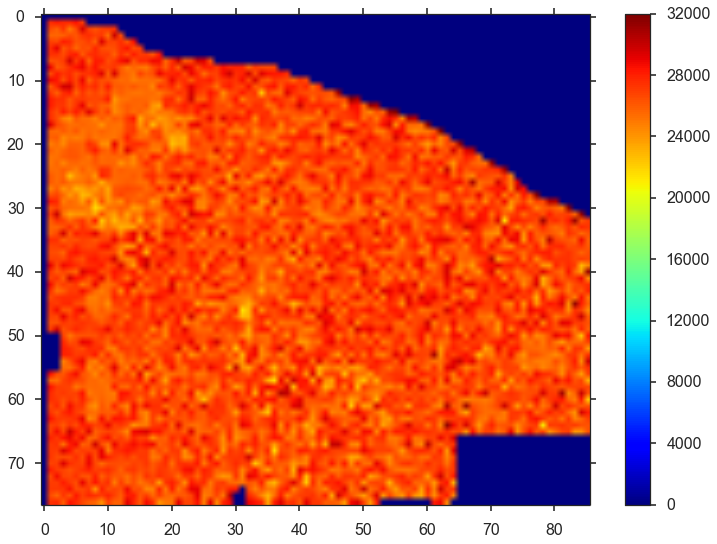

In [9]:
meanBM = np.zeros((77,86), dtype=np.float)
meanBMz = np.zeros((77,86), dtype=np.float)
idx = 0
for iteration in iterations_f:
    print iteration
    totalBM = np.zeros((77,86), dtype=np.float)
    totalBMz = np.zeros((77,86), dtype=np.float)

    count = 0
    MapNames_f = []
    gen = dirs(iteration)
    for names in gen:
        MapNames_f.append(iteration + '/' + names)
    sevmaps = []
    gen = files(MapNames_f[4])
    for names in gen:
        sevmaps.append(MapNames_f[4] + '/' + names)
    
    for sevmap in sevmaps:
        ds = gdal.Open(sevmap)
        band = ds.GetRasterBand(1)
        #band.SetNoDataValue(0)
        biomass = band.ReadAsArray()
        biomass = biomass.astype(float)
        biomass[biomass == 1] = 0

        totalBM = totalBM + biomass
        totalBMz = np.dstack((totalBMz, biomass))
    if idx == 0:
        meanBMz = totalBMz
    else:
        meanBMz = (meanBMz + totalBMz) / 2
        print idx
        count = count + 1
    idx = idx + 1
        
plt.imshow(meanBMz.sum(axis=2), cmap = 'jet')
plt.colorbar()




In [12]:
meanBMz.shape[1]

86

<matplotlib.colorbar.Colorbar instance at 0x7f1dc27ce5a8>

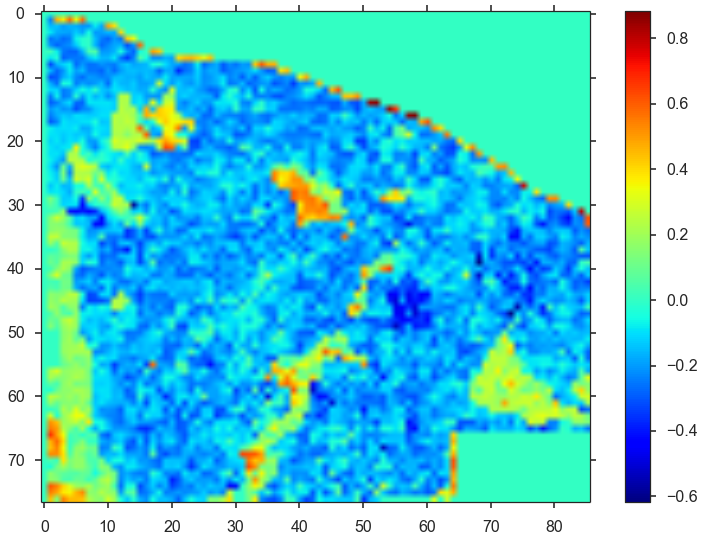

In [49]:
def linearFit(rasterStack):
    # Example linear fit over 5 replicates of 100 years of simulation
    # negative values indicate decreased NPP, positive values indicate increased NPP
    fitRaster = np.zeros((rasterStack.shape[0],rasterStack.shape[1]), 
                         dtype=np.float)
    for row in np.arange(0,rasterStack.shape[0]):
        for column in np.arange(0,rasterStack.shape[1]):
            x = np.arange(0,rasterStack.shape[2])
            y = rasterStack[row][column][:]
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            fitRaster[row][column] = z[0]
    return fitRaster

testRaster = linearFit(meanBMz)
plt.imshow(testRaster, cmap = 'jet')
plt.colorbar()

array([ 0.,  0.])